In [1]:
# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [2]:
# URL to download from repository assets
data_source = "inv_gravity_anomaly_3d_files.tar.gz"

# download the data
# downloaded_data = download(data_source, overwrite=True)
downloaded_data = data_source

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "gravity_topo.txt"
data_filename = dir_path + "gravity_data.obs"

In [3]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

In [5]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

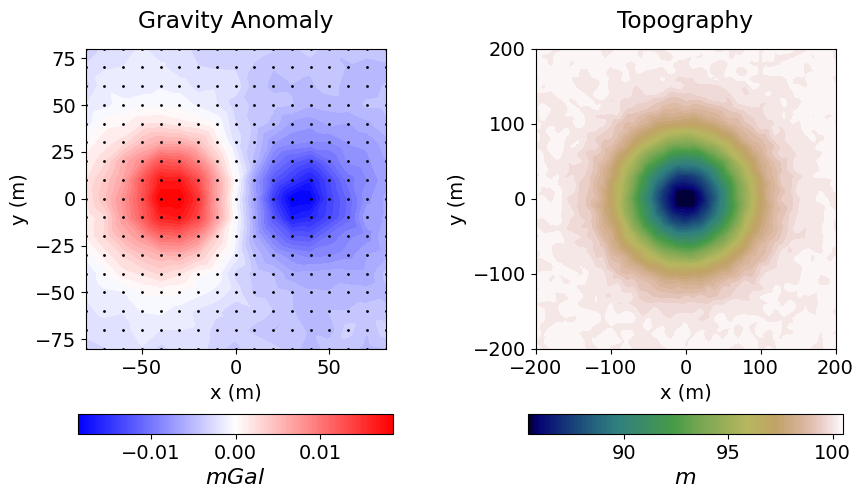

In [6]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz[:, 0:2],
    topo_xyz[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz[:, -1]), vmax=np.max(topo_xyz[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)

plt.show()

In [7]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.02 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.00037204


In [8]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [9]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion on a Tensor Mesh

In [10]:
# Generate tensor mesh with top at z = 0 m
dh = 5.0  # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 15)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

In [11]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

In [12]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [13]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [14]:
# starting_tensor_model

array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06])

In [16]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

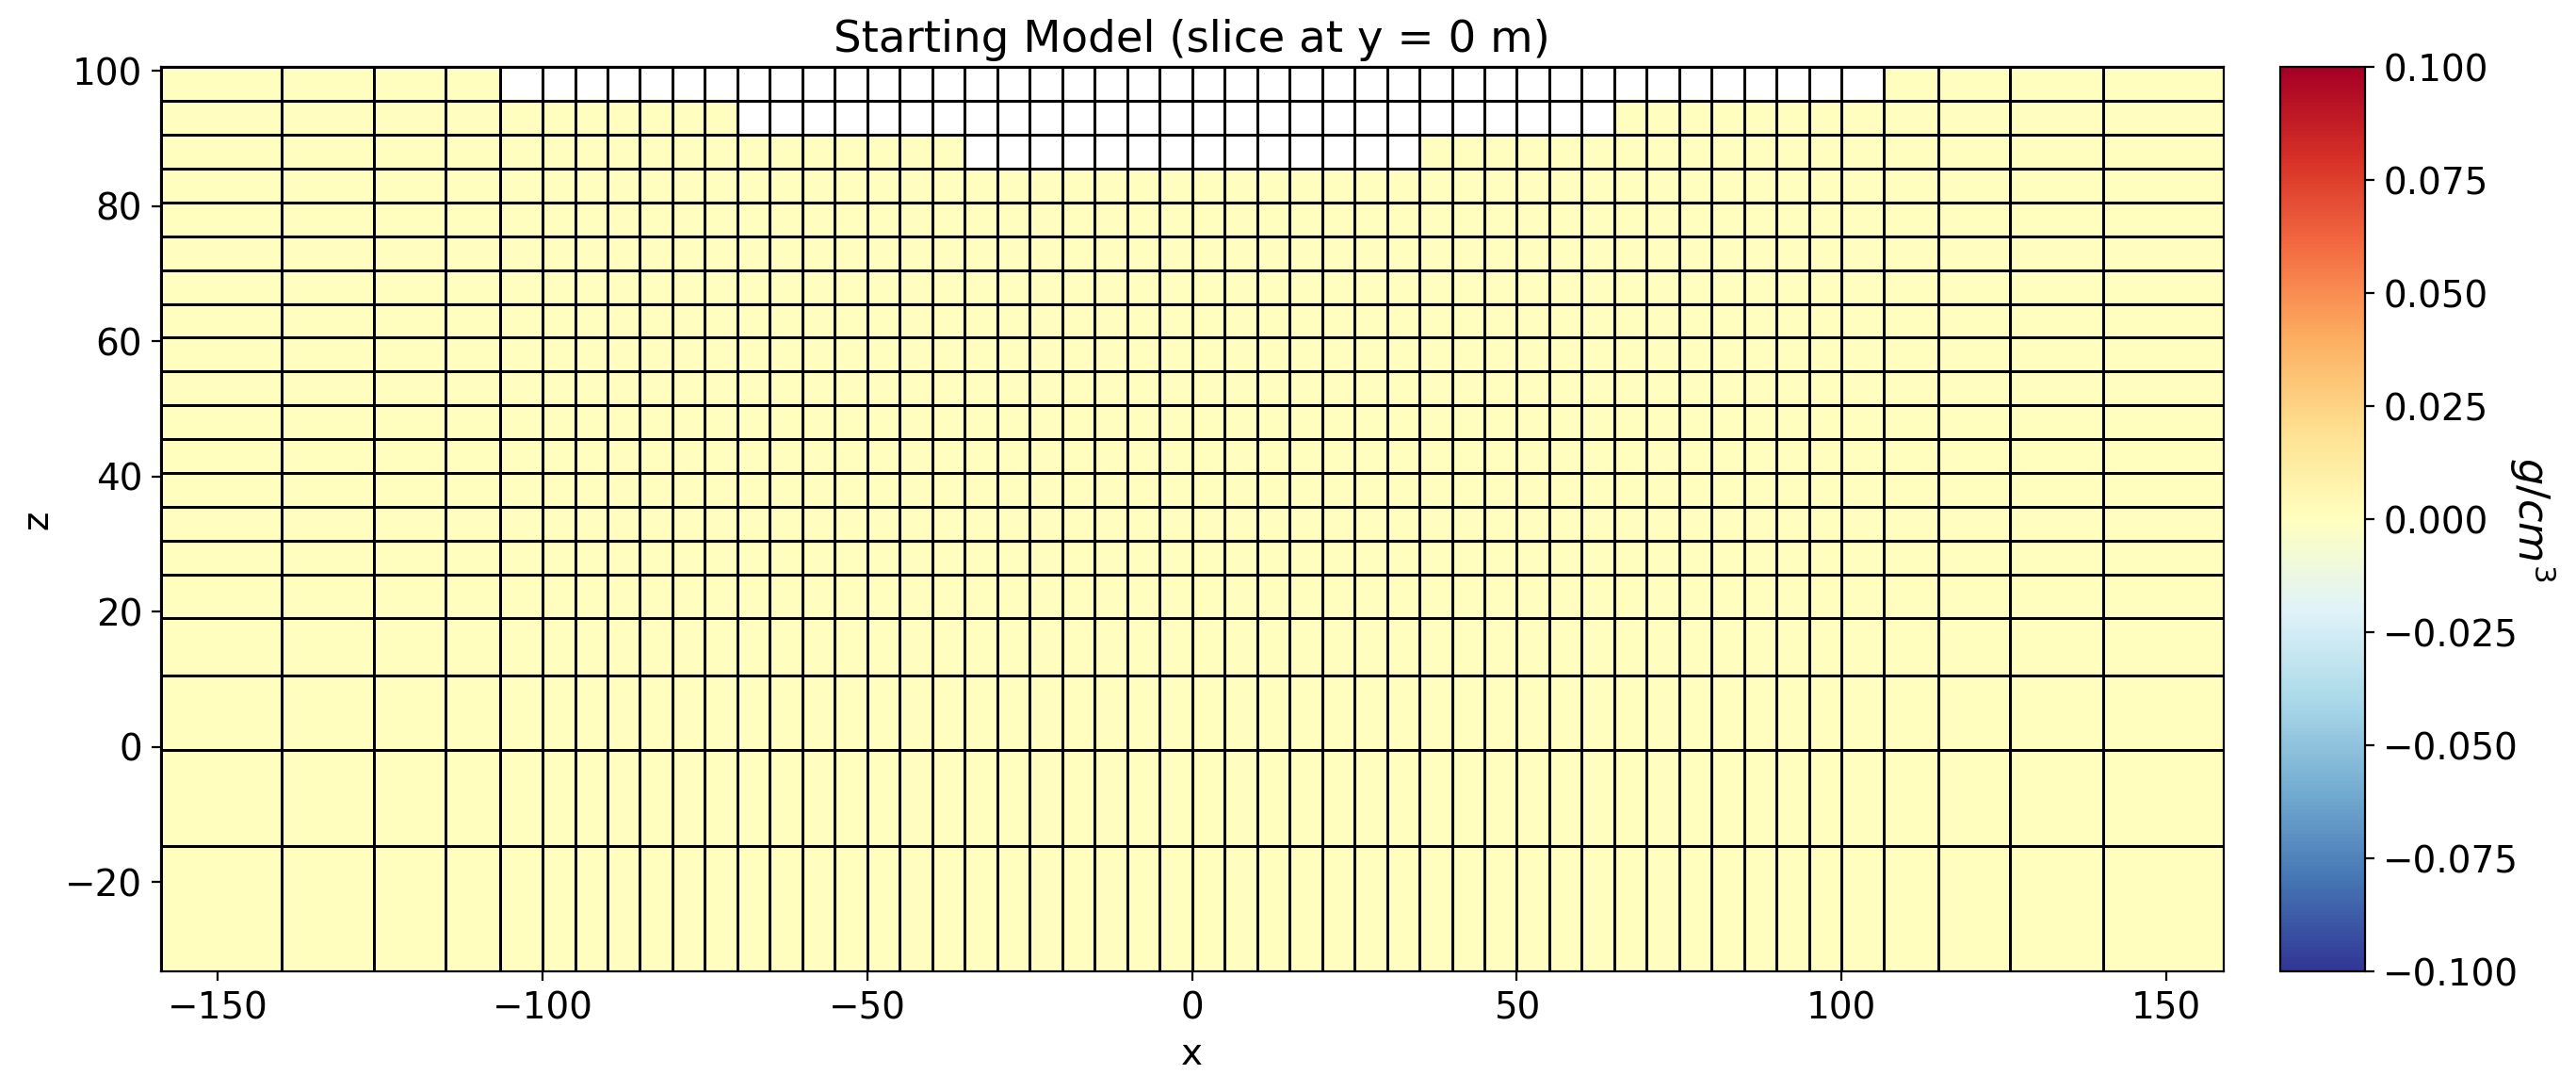

In [17]:
fig = plt.figure(figsize=(15, 6), dpi=200)
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [18]:
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="geoana",
)

In [19]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

In [20]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

In [27]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

In [30]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### 1. **Data Misfit**

The data misfit $\phi_d$ is defined as:

$$
\phi_d(m) = \frac{1}{2} \sum_{i=1}^N \left( \frac{d_i^{\text{obs}} - d_i^{\text{pred}}(m)}{\sigma_i} \right)^2
$$

Where:

- $d_i^{\text{obs}}$: Observed data
- $d_i^{\text{pred}}(m)$: Predicted data for model $m$
- $\sigma_i$: Data uncertainties
- $N$: Number of data points

### 2. **Sensitivity Weighting**

The sensitivity weighting $W_s$ applied to the model $m$:

$$
\phi_s(m) = \frac{1}{2} \| W_s (m - m_{\text{ref}}) \|^2
$$

Where:

- $W_s$: Sensitivity weighting matrix
- $m_{\text{ref}}$: Reference model

### 3. **Trade-off Parameter (Beta)**

The trade-off parameter $\beta$ balances the data misfit $\phi_d$ and the model regularization $\phi_m$:

$$
\Phi(m) = \phi_d(m) + \beta \phi_m(m)
$$

The initial value of $\beta$ is often estimated using the largest eigenvalue $\lambda_{\max}$ of the matrix $\mathbf{J}^\top \mathbf{J}$ (Jacobian):

$$
\beta_0 = \lambda_{\max}
$$

### 4. **Preconditioning**

The Jacobi preconditioner $M^{-1}$ is applied as follows:

$$
M^{-1} = \text{diag} \left( \mathbf{J}^\top \mathbf{J} + \beta \mathbf{I} \right)
$$

Where:

- $M$: Preconditioning matrix
- $\mathbf{J}$: Jacobian matrix
- $\mathbf{I}$: Identity matrix


In [28]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

In [31]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.23e+03  5.58e+04  6.08e-07  5.58e+04    2.09e+05      0              
   1  4.11e+03  2.21e+04  1.27e+00  2.73e+04    4.97e+04      0              
   2  2.06e+03  1.47e+04  2.55e+00  1.99e+04    3.72e+04      0   Skip BFGS  
   3  1.03e+03  8.65e+03  4.63e+00  1.34e+04    2.63e+04      0   Skip BFGS  
   4  5.14e+02  4.48e+03  7.48e+00  8.32e+03    1.74e+04      0   Skip BFGS  
   5  2.57e+02  2.10e+03  1.07e+01  4.85e+03    1.07e+04      0   Skip BFGS  
   6  1.29e+02  9.48e+

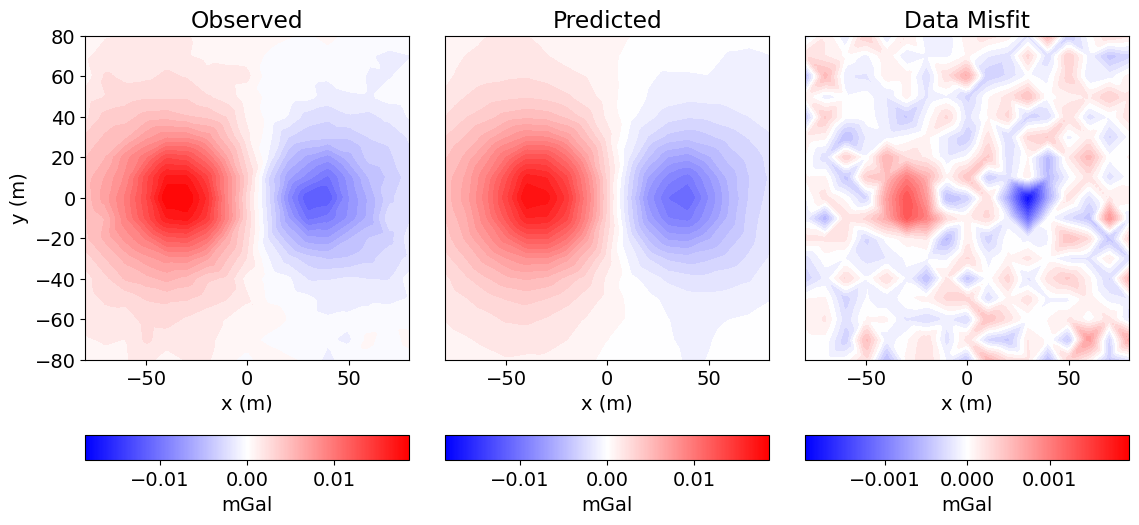

In [32]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

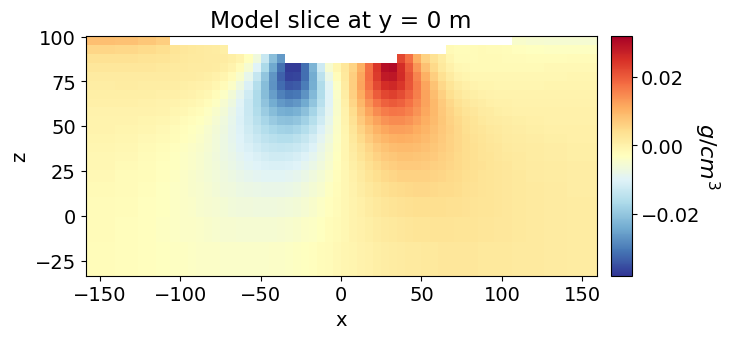

In [33]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [34]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

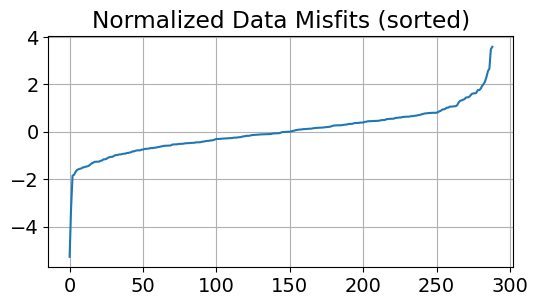

In [35]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [36]:
# Generate new uncertainties
new_uncertainties = uncertainties.copy()
new_uncertainties[np.abs(normalized_data_misfits) > 2.0] /= 2.5

In [37]:
# Generate new data object
new_data_object = data.Data(survey, dobs=dobs, standard_deviation=new_uncertainties)

In [38]:
dx = 5  # minimum cell width (base tree_mesh cell width) in x
dy = 5  # minimum cell width (base tree_mesh cell width) in y
dz = 5  # minimum cell width (base tree_mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base tree_mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base tree_mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
tree_mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Shift vertically to top same as maximum topography
tree_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

# Refine based on surface topography
tree_mesh.refine_surface(topo_xyz, padding_cells_by_level=[2, 2], finalize=False)

# Refine box based on region of interest
wsb_corner = np.c_[-100, -100, 20]
ent_corner = np.c_[100, 100, 100]
# Note -1 is a flag for smallest cell size
tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

tree_mesh.finalize()

In [39]:
active_tree_cells = active_from_xyz(tree_mesh, topo_xyz)
n_tree_active = int(active_tree_cells.sum())

In [40]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [41]:
starting_tree_model = 1e-6 * np.ones(n_tree_active)
reference_tree_model = np.zeros_like(starting_tree_model)

In [42]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=tree_mesh, rhoMap=tree_model_map, ind_active=active_tree_cells
)

In [43]:
dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)

In [44]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=dh**-2,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
    reference_model=reference_tree_model,
    reference_model_in_smooth=False,
    norms=[0, 1, 1, 1],
)

In [45]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

In [46]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [47]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=False)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.Update_IRLS(
    coolingFactor=2,
    coolingRate=1,
    chifact_start=1.0,
    f_min_change=1e-4,
    max_irls_iterations=25,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

In [48]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.32e+06  1.17e+05  1.34e-08  1.17e+05    1.99e+02      0              
   1  2.66e+06  9.67e+04  1.70e-03  1.01e+05    1.98e+02      0              
   2  1.33e+06  8.45e+04  5.07e-03  9.12e+04    1.97e+02      0   Skip BFGS  
   3  6.65e+05  6.89e+04  1.36e-02  7.80e+04    1.97e+02      0   Skip BFGS  
   4  3.32e+05  5.15e+04  3.25e-02  6.23e+04    1.96e+02      0   Skip BFGS  
   5  1.66e+05  3.46e+04  6.91e-02  4.61e+04    1.94e+02      0   Skip BFGS  
   6  8.31e+04  2.03e+

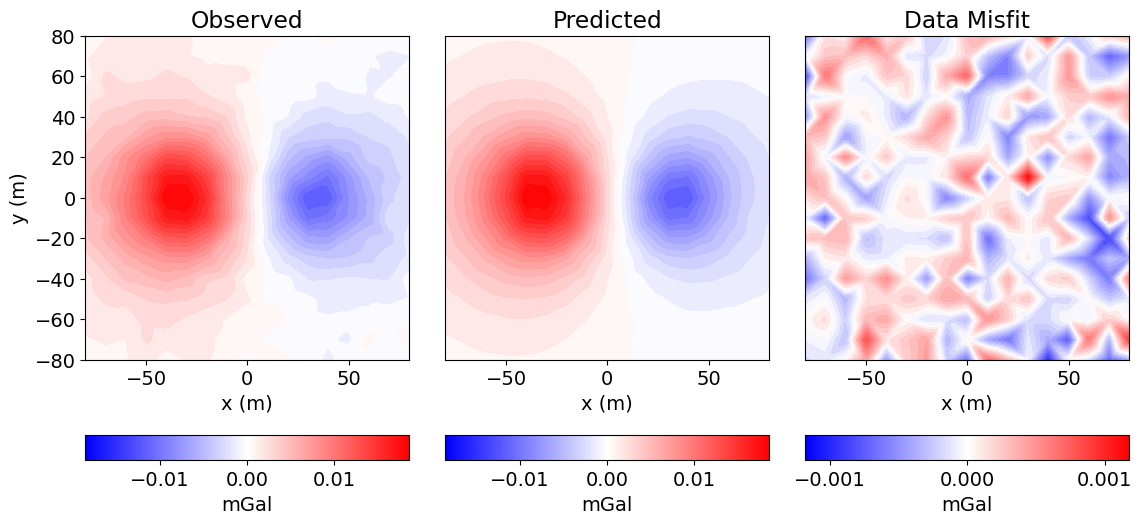

In [49]:
# Predicted data with final recovered model.
dpred_new = inv_prob_irls.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred_new, dobs - dpred_new]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred_new))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

In [50]:
# Recreate True Model on a Tensor Mesh
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

true_model = background_density * np.ones(n_tensor_active)

ind_block = model_builder.get_indices_block(
    [-50, -15, 50], [-20, 15, 70], tensor_mesh.cell_centers[active_tensor_cells]
)
true_model[ind_block] = block_density

ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, 60.0], 14.0, tensor_mesh.cell_centers[active_tensor_cells]
)
true_model[ind_sphere] = sphere_density

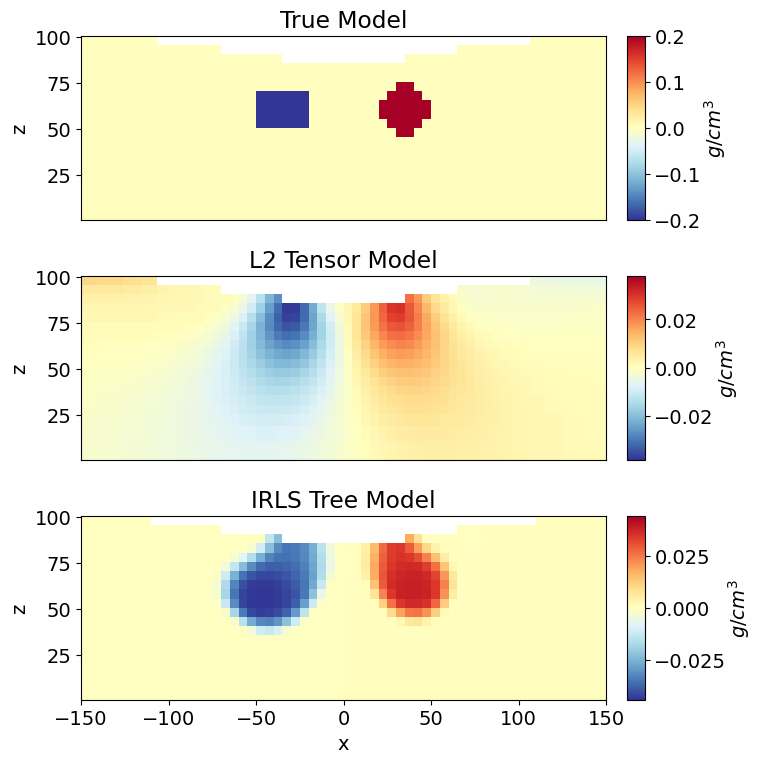

In [51]:
# Plot all models
mesh_list = [tensor_mesh, tensor_mesh, tree_mesh]
ind_list = [active_tensor_cells, active_tensor_cells, active_tree_cells]
model_list = [true_model, recovered_tensor_model, recovered_tree_model]
title_list = ["True Model", "L2 Tensor Model", "IRLS Tree Model"]
cplot = 3 * [None]
cbar = 3 * [None]
norm = 3 * [None]

fig = plt.figure(figsize=(7, 8))
ax1 = [fig.add_axes([0.1, 0.7 - 0.3 * ii, 0.75, 0.23]) for ii in range(0, 3)]
ax2 = [fig.add_axes([0.88, 0.7 - 0.3 * ii, 0.025, 0.23]) for ii in range(0, 3)]

for ii, mesh in enumerate(mesh_list):
    plotting_map = maps.InjectActiveCells(mesh, ind_list[ii], np.nan)
    max_abs = np.max(np.abs(model_list[ii]))
    norm[ii] = mpl.colors.Normalize(vmin=-max_abs, vmax=max_abs)

    cplot[ii] = mesh.plot_slice(
        plotting_map * model_list[ii],
        normal="Y",
        ax=ax1[ii],
        ind=int(mesh.shape_cells[1] / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm[ii]},
    )
    ax1[ii].set_xlim([-150, 150])
    ax1[ii].set_ylim([topo_xyz[:, -1].max() - 100, topo_xyz[:, -1].max()])
    if ii < 2:
        ax1[ii].set_xlabel("")
        ax1[ii].set_xticks([])
    ax1[ii].set_title(title_list[ii])

    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar[ii].set_label("$g/cm^3$", labelpad=0)